# Lights model tutorial

In [1]:
%reset -f
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tick.plot import plot_point_process
from lights.simulation import SimuJointLongitudinalSurvival
from sklearn.model_selection import ShuffleSplit
from lifelines.utils import concordance_index as c_index_score

/home/acsi/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/acsi/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/acsi/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/acsi/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:5

[0 1 1 0 0 0 0 0 0 1 1 0 0 1 1 0 1 1 0 0 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 1 0
 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0
 1 0 0 1 1 0 1 0 0 1 0 0 1 1 1 1 0 0 1 0 0 0 1 1 1 1]
[ 3.54810046  6.59992118  2.61935883  0.6887982   3.46678038  6.73070825
  8.85477888  3.16725303  2.17450572  5.59811794  0.02273862  3.51276729
  4.65124453  3.93249816  8.196966   14.68537622  6.01078509  3.84989121
 12.63204647  5.39022833  7.05638453  5.23551578  4.82934326  4.26886352
  1.12322821  6.81655428  4.49188439  0.99216527  7.57476829  4.09812873
  3.11215139 11.39084296 10.29610233 10.81615802  4.05510032  5.25916597
  4.378789    2.67212549  5.43467751  8.19466449  6.41577101  8.54879944
 10.9051862   6.64215602  7.48867959  7.39631732  2.69305589  6.90560246
 13.7403764   7.34373765  2.42130072  5.73295129  7.41555055  4.06233322
  4.13990182 13.17537506  5.22731147  9.83456659  1.5213592   4.91932511
  7.02486481  8.16407318]
[3.25355451 5.60197813 1.54814505 0.1921

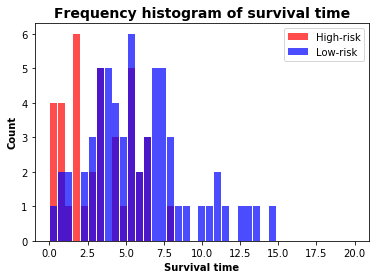

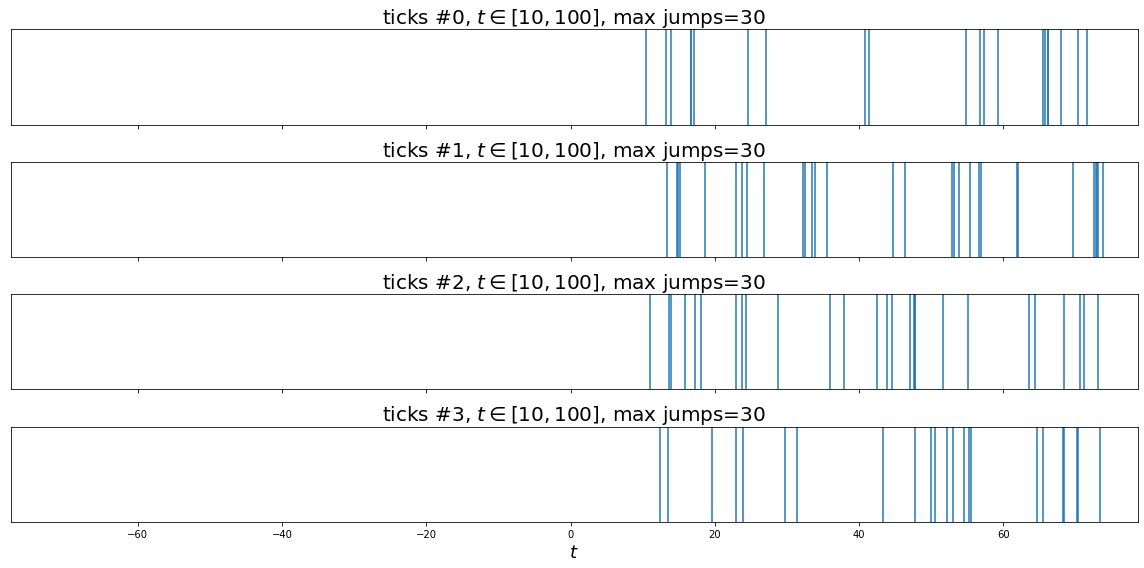

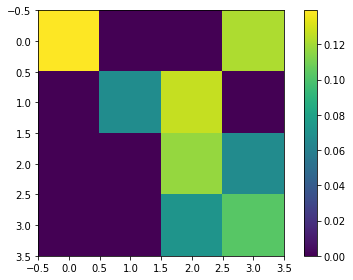

In [3]:
# Generate data
n_long_features = 4
# simu = SimuJointLongitudinalSurvival(n_long_features=n_long_features, seed = 123)
simu = SimuJointLongitudinalSurvival(n_samples=100,
                                             n_time_indep_features=3,
                                             n_long_features=4,
                                             gap=0.5,
                                             cov_corr_long = .1,
                                             seed=123, verbose=False,
                                             scale=.5, shape=.5)
simu.simulate()

hawkes = simu.hawkes
adjacency = hawkes.adjacency

fig, ax = plt.subplots(n_long_features, 1, figsize=(16, 8), sharex=True, sharey=True)
plot_point_process(hawkes, n_points=50000, t_min=10, max_jumps=30, ax=ax)
fig.tight_layout()

plt.figure()
plt.imshow(adjacency)
plt.colorbar()
plt.tight_layout()

## Data splitting

In [ ]:
## Assign index for each feature ##
features_names = range(X.shape[1]) 
n_samples, n_features = X.shape

## Split data into training and test sets ##
test_size = .3  # proportion of data used for testing
rs = ShuffleSplit(n_splits=1, test_size=test_size, random_state=0)

for train_index, test_index in rs.split(X):
    X_test = X[test_index]
    delta_test = delta[test_index]
    Y_test = Y[test_index]

    X = X[train_index]
    Y = Y[train_index]
    delta = delta[train_index]  
    
print("%d%% for training, %d%% for testing." 
      % ((1 - test_size) * 100, test_size * 100))

## Training 

In [ ]:
## Choose parameters ##
tol = 1e-6            # tolerance for the convergence stopping criterion 
eta = 0.3             # parameter controlling the trade-off between l1 
                      # and l2 regularization in the elasticNet
gamma_chosen = '1se'  # way to select l_elasticNet_chosen: '1se' or 'min'
warm_start = True     # at each L-BGFS-B iteration, reset beta to 0 or take 
                      # the previous value 
grid_size = 30        # grid size for the cross validation procedure
metric = 'C-index'    # cross-validation metric: 'log_lik' or 'C-index'

# declare learner here        

## Cross-validation ##

## Run selected model with l_elasticNet_chosen ##

# run final fit here

## Prediction

In [ ]:
## Obtain the marker vector on test set ##

# prediction here

#c_index = c_index_score(Y_test, marker, delta_test)
#c_index = max(c_index, 1 - c_index)

print("Done predicting on test set.")
#print("C-index : %.2f" % c_index)

## Figures

### Learning curves

### Convergence

### Beta coefficients